In [ ]:
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 8.5 MB/s eta 0:00:00


In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=04a8b4be53c841ab9144b57d8837fcc9292bc889c6de0e26782ee18c5dba9b43
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving data.txt to data.txt


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import optuna
import math
from tqdm import tqdm
from scipy.stats import norm
import cv2
import lime
import lime.lime_tabular

# Suppress optuna logging
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Default data path
DEFAULT_DATA_PATH = 'data.txt'

# Constants
FAMOUS_ARTISTS = [
    'Pablo Picasso', 'Andy Warhol', 'Gustav Klimt', 'Paul Cezanne',
    'Edvard Munch', 'Vincent van Gogh', 'Mark Rothko', 'Leonardo da Vinci'
]

MATERIALS = [
    'oil on canvas', 'acrylic on canvas', 'watercolor', 'charcoal', 'pastel',
    'ink on paper', 'mixed media on canvas', 'oil on panel', 'acrylic on wood',
    'oil on board', 'bronze', 'plaster', 'gouache', 'tempera on board', 'ceramic',
    'wood', 'metal', 'stone', 'fabric', 'mixed media', 'oil and acrylic',
    'acrylic and collage on canvas', 'oil on paper', 'oil on wood', 'oil on cardboard',
    'acrylic on paper', 'gouache and watercolor on paper', 'ink and watercolor on paper',
    'oil and mixed media on canvas', 'acrylic and spray paint on canvas', 'oil on copper',
    'oil on plywood'
]


REGIONS = {
    # Define your region mapping here
    'Swiss': 'Europe', 'French': 'Europe', 'American': 'North America', 'European': 'Europe',
    'Danish': 'Europe', 'Chinese': 'Asia', 'Taiwanese': 'Asia', 'British': 'Europe',
    'Iranian': 'Asia', 'Dutch': 'Europe', 'German': 'Europe', 'Norwegian': 'Europe',
    'Swedish': 'Europe', 'Finnish': 'Europe', 'Hungarian': 'Europe', 'Italian': 'Europe',
    'Filipino': 'Asia', 'Spanish': 'Europe', 'Croatian': 'Europe', 'Polish': 'Europe',
    'Argentine': 'South America', 'Chilean': 'South America', 'Mexican': 'North America',
    'Azerbaijani': 'Asia', 'Russian': 'Europe', 'Belgian': 'Europe', 'Malaysian': 'Asia',
    'Iraqi': 'Asia', 'Persian': 'Asia', 'Austrian': 'Europe', 'Australian': 'Oceania',
    'Lebanese': 'Asia', 'Palestinian': 'Asia', 'Egyptian': 'Africa', 'Syrian': 'Asia',
    'Algerian': 'Africa', 'Turkish': 'Asia', 'Mozambican': 'Africa', 'Javanese': 'Asia',
    'Armenian': 'Asia', 'Japanese': 'Asia', 'Israeli': 'Asia', 'Bangladeshi': 'Asia',
    'Indonesian': 'Asia', 'Cuban': 'North America', 'Haitian': 'North America',
    'NewZealand': 'Oceania', 'Indian': 'Asia', 'Moroccan': 'Africa', 'Libyan': 'Africa',
    'Georgian': 'Asia', 'Yugoslav': 'Europe', 'Lithuanian': 'Europe', 'SouthAfrican': 'Africa',
    'Guatemalan': 'North America', 'Flemish': 'Europe', 'Czech': 'Europe', 'Greek': 'Europe',
    'Canadian': 'North America', 'Uruguayan': 'South America', 'Colombian': 'South America',
    'Venezuelan': 'South America', 'Scottish': 'Europe', 'NorthAmerican': 'North America',
    'Estonian': 'Europe', 'Irish': 'Europe', 'Nigerian': 'Africa', 'Balinese': 'Asia',
    'Romanian': 'Europe', 'Portuguese': 'Europe', 'Pakistani': 'Asia', 'Korean': 'Asia',
    'PuertoRican': 'North America', 'Scandinavian': 'Europe', 'Emirati': 'Asia',
    'Thai': 'Asia', 'Serbian': 'Europe', 'Sudanese': 'Africa', 'Dominican': 'North America',
    'LatinAmerican': 'South America', 'Peruvian': 'South America', 'SouthAmerican': 'South America',
    'Welsh': 'Europe', 'Singaporean': 'Asia', 'Brazilian': 'South America', 'Cambodian': 'Asia',
    'NativeAmerican': 'North America', 'Continental': 'Europe', 'Senegalese': 'Africa',
    'Qatari': 'Asia', 'Jordanian': 'Asia', 'Beninese': 'Africa', 'Asian': 'Asia',
    'Mongolian': 'Asia', 'Tanzanian': 'Africa', 'Vietnamese': 'Asia', 'Latvian': 'Europe',
    'Zimbabwean': 'Africa', 'Ecuadorian': 'South America', 'Ghanaian': 'Africa',
    'Tunisian': 'Africa', 'Luxembourger': 'Europe', 'Slovak': 'Europe', 'Uzbekistani': 'Asia',
    'Congolese': 'Africa', 'Bahamian': 'North America', 'Bulgarian': 'Europe',
    'CostaRican': 'North America', 'Bolivian': 'South America', 'Albanian': 'Europe',
    'Nicaraguan': 'North America', 'Ukrainian': 'Europe', 'African': 'Africa',
    'Bahraini': 'Asia'
}


In [ ]:
def extract_image_features(image_path):
    """Extract comprehensive image features including the dominant color and face count"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("Could not read image")

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        brightness = np.mean(img_rgb)
        unique_colors = len(np.unique(img_rgb.reshape(-1, 3), axis=0))
        ratio_unique_colors = unique_colors / (img_rgb.shape[0] * img_rgb.shape[1])
        threshold_black = np.sum(img_gray < 30) / (img_gray.shape[0] * img_gray.shape[1])
        high_brightness = np.sum(img_gray > 200) / (img_gray.shape[0] * img_gray.shape[1])
        low_brightness = np.sum(img_gray < 50) / (img_gray.shape[0] * img_gray.shape[1])
        edges = cv2.Canny(img_gray, 100, 200)
        edge_percentage = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
        corners = cv2.goodFeaturesToTrack(img_gray, maxCorners=100, qualityLevel=0.01, minDistance=10)
        corner_percentage = len(corners) / (img_gray.shape[0] * img_gray.shape[1]) if corners is not None else 0

        cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        face_cascade = cv2.CascadeClassifier(cascade_path)

        faces = face_cascade.detectMultiScale(img_gray, scaleFactor=1.2, minNeighbors=5, minSize=(30, 30))
        face_count = len(faces) if len(faces) > 0 else 0

        pixels = np.float32(img_rgb).reshape(-1, 3)
        n_colors = 5
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
        _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        _, counts = np.unique(labels, return_counts=True)

        dominant_color = palette[np.argmax(counts)].astype(int)

        colors = {
            'red': [255, 0, 0], 'green': [0, 255, 0], 'blue': [0, 0, 255],
            'yellow': [255, 255, 0], 'white': [255, 255, 255], 'black': [0, 0, 0],
            'brown': [165, 42, 42], 'maroon': [128, 0, 0], 'orange': [255, 165, 0],
            'purple': [128, 0, 128], 'pink': [255, 192, 203], 'gray': [128, 128, 128]
        }

        dominant_color_name = min(colors.keys(), key=lambda x: np.linalg.norm(np.array(colors[x]) - dominant_color))

        return {
            'brightness': float(brightness),
            'ratioUniqueColors': float(ratio_unique_colors),
            'thresholdBlackPerc': float(threshold_black),
            'highbrightnessPerc': float(high_brightness),
            'lowbrightnessPerc': float(low_brightness),
            'CornerPer': float(corner_percentage),
            'EdgePer': float(edge_percentage),
            'FaceCount': int(face_count),
            'dominantColor': str(dominant_color_name)
        }

    except Exception as e:
        print(f"Error processing image: {e}")
        return {
            'brightness': 0.0, 'ratioUniqueColors': 0.0, 'thresholdBlackPerc': 0.0,
            'highbrightnessPerc': 0.0, 'lowbrightnessPerc': 0.0, 'CornerPer': 0.0,
            'EdgePer': 0.0, 'FaceCount': 0, 'dominantColor': 'unknown'
        }


In [ ]:
from category_encoders import TargetEncoder

def clean_and_prepare_data(df):
    """Clean and prepare the dataset for training"""
    df_clean = df.copy()

    if 'soldtime' in df_clean.columns:
        df_clean.drop(columns=['soldtime'], inplace=True)

    required_columns = ['year', 'height', 'width', 'artist', 'material', 'price']
    missing_cols = [col for col in required_columns if col not in df_clean.columns]
    if missing_cols:
        print(f"Missing required columns: {missing_cols}")
        return None, None, None, None, None

    numeric_cols = ['year', 'height', 'width', 'price']
    for col in numeric_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        col_median = df_clean[col].median(skipna=True)
        df_clean[col] = df_clean[col].fillna(col_median).astype('float32' if col in ['height', 'width', 'price'] else 'int16')

    df_clean['log_price'] = np.log1p(df_clean['price'])
    df_clean['area'] = df_clean['height'] * df_clean['width']
    df_clean['log_area'] = np.log1p(df_clean['area'])
    df_clean['aspect_ratio'] = df_clean['height'] / df_clean['width']
    df_clean['is_famous_artist'] = df_clean['artist'].isin(FAMOUS_ARTISTS).astype('int8')
    df_clean['artwork_age'] = 2025 - df_clean['year']

    y = df_clean['log_price'].values  # <-- get y early to use with encoders

    encoder_artist = TargetEncoder(cols=['artist'])
    encoder_material = TargetEncoder(cols=['material'])
    df_clean['artist_encoded'] = encoder_artist.fit_transform(df_clean[['artist']], y)['artist']
    df_clean['material_encoded'] = encoder_material.fit_transform(df_clean[['material']], y)['material']

    if 'country' in df_clean.columns:
        df_clean['region'] = df_clean['country'].map(REGIONS).fillna('Other')
        encoder_region = TargetEncoder(cols=['region'])
        df_clean['region_encoded'] = encoder_region.fit_transform(df_clean[['region']], y)['region']
    else:
        df_clean['region_encoded'] = 0
        encoder_region = TargetEncoder(cols=['region'])  # dummy encoder

    feature_columns = [
        'material_encoded', 'artist_encoded', 'region_encoded', 'year', 'log_area',
        'aspect_ratio', 'is_famous_artist', 'artwork_age'
    ]

    image_features = ['brightness', 'ratioUniqueColors', 'thresholdBlackPerc',
                      'highbrightnessPerc', 'lowbrightnessPerc', 'CornerPer',
                      'EdgePer', 'FaceCount']
    for feat in image_features:
        if feat in df_clean.columns:
            df_clean[feat] = pd.to_numeric(df_clean[feat], errors='coerce').fillna(0)
            feature_columns.append(feat)

    X = df_clean[feature_columns].values

    return X, y, (encoder_artist, encoder_material, encoder_region), feature_columns, df_clean


In [ ]:
import numpy as np
import pandas as pd
import optuna
import joblib
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor

def introduce_noise(X, noise_level=0.1):
    """Introduce Gaussian noise to numeric features"""
    X_noisy = X.copy()
    feature_indices = {name: i for i, name in enumerate([
        'material_encoded', 'artist_encoded', 'region_encoded', 'brightness', 'ratioUniqueColors',
        'thresholdBlackPerc', 'highbrightnessPerc', 'lowbrightnessPerc', 'CornerPer', 'EdgePer',
        'FaceCount', 'is_famous_artist', 'year', 'log_area', 'aspect_ratio', 'artwork_age'
    ])}

    continuous_features = [
        'brightness', 'ratioUniqueColors', 'thresholdBlackPerc', 'highbrightnessPerc',
        'lowbrightnessPerc', 'CornerPer', 'EdgePer', 'FaceCount', 'log_area', 'aspect_ratio',
        'artwork_age'
    ]
    for feature in continuous_features:
        if feature in feature_indices:
            index = feature_indices[feature]
            noise = np.random.normal(0, noise_level, X_noisy[:, index].shape)
            X_noisy[:, index] += noise
    return X_noisy

def objective(trial, X_train, y_train, X_valid, y_valid):
    """Objective function for hyperparameter optimization"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return mean_absolute_percentage_error(y_valid, y_pred)

def train_model(data_path='data.txt'):
    print("Loading and preparing data...")
    df = pd.read_table(data_path, low_memory=False)

    X, y, encoders, feature_columns, df_clean = clean_and_prepare_data(df)

    if X is None or y is None:
        print("Data preparation failed. Exiting.")
        return None, None, None, None

    X_noisy = introduce_noise(X, noise_level=0.1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_noisy, y, test_size=0.2, random_state=42)

    print("Optimizing hyperparameters...")
    study = optuna.create_study(direction='minimize')

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    for train_index, val_index in tqdm(kf.split(X_train), total=3, desc="Cross-Validation"):
        X_kf_train, X_kf_val = X_train[train_index], X_train[val_index]
        y_kf_train, y_kf_val = y_train[train_index], y_train[val_index]

        study.optimize(lambda trial: objective(trial, X_kf_train, y_kf_train, X_kf_val, y_kf_val), n_trials=10)

    best_params = study.best_params
    model = RandomForestRegressor(**best_params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)
    r2 = r2_score(y_valid, y_pred)
    mae = mean_absolute_error(y_valid, y_pred)

    print(f"\nModel Performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")

    # Save everything to Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    SAVE_DIR = "/content/drive/MyDrive/price_prediction_model"
    os.makedirs(SAVE_DIR, exist_ok=True)

    model_bundle = {
        "model": model,
        "encoders": encoders,
        "std_dev": np.std(y_valid - y_pred),
        "feature_columns": feature_columns,
        "dataframe": df_clean
    }

    joblib.dump(model_bundle, os.path.join(SAVE_DIR, "model_bundle.joblib"))
    print(f"\nModel bundle saved to {SAVE_DIR}/model_bundle.joblib")

    return model, encoders, np.std(y_valid - y_pred), feature_columns, df_clean


In [ ]:
def print_feature_importances(model, feature_columns):
    """Print feature importances from the model"""
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print("\nFeature Importances:")
    print(feature_importance_df)


In [ ]:
def explain_with_lime(model, X_train, feature_columns, inputs):
    """Use LIME to explain the model's predictions"""
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_columns, mode='regression')

    # Convert inputs dictionary to DataFrame
    input_df = pd.DataFrame([inputs], columns=feature_columns)

    # Explain the prediction
    exp = explainer.explain_instance(input_df.values[0], model.predict, num_features=10)
    exp.show_in_notebook(show_table=True)

In [ ]:
model, encoders, std_dev, feature_columns, df_clean = train_model('data.txt')


Loading and preparing data...
Optimizing hyperparameters...


Cross-Validation: 100%|██████████| 3/3 [44:04<00:00, 881.45s/it]



Model Performance:
R² Score: 0.8385
Mean Absolute Error: 0.5894
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Model bundle saved to /content/drive/MyDrive/price_prediction_model/model_bundle.joblib


In [ ]:
def prepare_prediction_input(artist, year, height, width, material, country, encoders, feature_columns, image_features):
    inputs = {feature: 0 for feature in feature_columns}

    encoder_artist, encoder_material, encoder_region = encoders

    inputs['artist_encoded'] = encoder_artist.transform(pd.DataFrame({'artist': [artist]}))['artist'].iloc[0]
    inputs['material_encoded'] = encoder_material.transform(pd.DataFrame({'material': [material]}))['material'].iloc[0]
    region = REGIONS.get(country, 'Other')
    inputs['region_encoded'] = encoder_region.transform(pd.DataFrame({'region': [region]}))['region'].iloc[0]

    inputs['year'] = year
    inputs['log_area'] = np.log1p(height * width)
    inputs['aspect_ratio'] = height / width
    inputs['is_famous_artist'] = 1 if artist in FAMOUS_ARTISTS else 0
    inputs['artwork_age'] = 2025 - year

    for key, value in image_features.items():
        if key in inputs:
            inputs[key] = value
    return inputs

In [ ]:
def get_user_input():
    """Get and validate user input"""
    print("\n=== Art Price Prediction System ===")
    artist = input("Enter artist name (or 'Unknown'): ").strip() or "Unknown"

    while True:
        try:
            year = int(input("Enter year of creation: ").strip())
            height = float(input("Enter height (cm): ").strip())
            width = float(input("Enter width (cm): ").strip())
            if year > 0 and height > 0 and width > 0:
                break
            print("Please enter positive numbers.")
        except ValueError:
            print("Please enter valid numbers.")

    # Print materials in 2-3 columns
    num_columns = 3
    num_rows = math.ceil(len(MATERIALS) / num_columns)

    print("Select material from the following options:")
    for row in range(num_rows):
        row_items = []
        for col in range(num_columns):
            index = row + col * num_rows
            if index < len(MATERIALS):
                row_items.append(f"{index + 1}: {MATERIALS[index]}")
            else:
                row_items.append("")  # Fill empty spaces
        print("\t".join(row_items))

    # Get material choice from predefined list
    while True:
        try:
            material_choice = int(input("Enter the number corresponding to the material: ")) - 1
            if 0 <= material_choice < len(MATERIALS):
                material = MATERIALS[material_choice]
                break
            else:
                print("Invalid choice. Please select a valid number.")
        except ValueError:
            print("Please enter a valid number.")

    countries = list(REGIONS.keys())
    print("\nSelect country (showing first few, type number):")
    for i in range(min(10, len(countries))):
        print(f"{i + 1}: {countries[i]}")
    print(f"{len(countries) + 1}: Other")
    while True:
        try:
            country_choice = int(input("Enter country number: ")) - 1
            if 0 <= country_choice < len(countries):
                country = countries[country_choice]
                break
            elif country_choice == len(countries):
                country = "Unknown"
                break
            print(f"Enter a number between 1 and {len(countries) + 1}.")
        except ValueError:
            print("Please enter a valid number.")

    return artist, year, height, width, material, country


In [ ]:
def predict_price_range(model, inputs, std_dev, feature_columns):
    """Predict price range with narrower confidence interval"""
    feature_vector = pd.DataFrame([inputs])[feature_columns]
    predicted_log_price = model.predict(feature_vector)[0]
    lower_bound = np.expm1(predicted_log_price - std_dev)  # 68% CI
    upper_bound = np.expm1(predicted_log_price + std_dev)
    return lower_bound, np.expm1(predicted_log_price), upper_bound

def plot_visualizations(lower_bound, predicted_price, upper_bound, artist, year, df):
    """Create enhanced visualizations"""
    plt.figure(figsize=(18, 12))

    # 1. Price Distribution
    plt.subplot(2, 2, 1)
    price_range = np.linspace(lower_bound * 0.8, upper_bound * 1.2, 100)
    std_dev = (upper_bound - lower_bound) / 2
    distribution = norm.pdf(price_range, loc=predicted_price, scale=std_dev)
    plt.axvline(predicted_price, color='red', linestyle='--', label=f'Predicted: ${predicted_price:,.2f}')
    plt.axvline(lower_bound, color='green', linestyle=':', label=f'Lower: ${lower_bound:,.2f}')
    plt.axvline(upper_bound, color='orange', linestyle=':', label=f'Upper: ${upper_bound:,.2f}')
    plt.fill_between(price_range, distribution, alpha=0.2)
    plt.xlabel('Price ($)')
    plt.ylabel('Probability Density')
    plt.title(f'Price Prediction Distribution\n{artist}, {year}')
    plt.legend()

    # 2. Price Trend Over Last 30 Years
    plt.subplot(2, 2, 2)
    trend_data = df.groupby(df['year'])['price'].mean()
    sns.lineplot(x=trend_data.index, y=trend_data.values, label='Avg Price Trend')
    plt.axvline(year, color='red', linestyle='--', label=f'Artwork Year: {year}')
    plt.xlabel('Year')
    plt.ylabel('Average Price ($)')
    plt.title('Price Trend (1995-2025)')
    plt.legend()

    # 3. Heatmap of Feature Correlations
    plt.subplot(2, 2, 3)
    numeric_cols = ['artist_encoded', 'material_encoded', 'log_area', 'year', 'artwork_age']
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Feature Correlation Heatmap')

    # 4. Price Range Bar
    plt.subplot(2, 2, 4)
    plt.bar(['Lower', 'Predicted', 'Upper'], [lower_bound, predicted_price, upper_bound], color=['green', 'red', 'orange'])
    plt.ylabel('Price ($)')
    plt.title('Price Range')

    plt.tight_layout()
    plt.show()


Initializing Art Price Prediction System...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully from Drive.

Feature Importances:
               Feature  Importance
1       artist_encoded    0.659491
0     material_encoded    0.178081
4             log_area    0.038226
3                 year    0.015330
7          artwork_age    0.013647
9    ratioUniqueColors    0.011987
5         aspect_ratio    0.010636
12   lowbrightnessPerc    0.010156
14             EdgePer    0.009923
15           FaceCount    0.009593
10  thresholdBlackPerc    0.009462
6     is_famous_artist    0.009181
8           brightness    0.008896
13           CornerPer    0.008711
2       region_encoded    0.004143
11  highbrightnessPerc    0.002538

=== Art Price Prediction System ===
Select material from the following options:
1: oil on canvas	12: plaster	23: oil on paper
2: acrylic on canvas	13: gouache	24: oil on w

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(



=== Price Prediction Results ===
Artist: Anton
Dimensions: 56.0cm x 76.0cm
Material: acrylic on paper
Country: SouthAfrican
Face Count: 0
Dominant Color: gray
Brightness: 139.82

Estimated price range: $3,885.13 - $20,761.18
Most likely price: $8,981.46


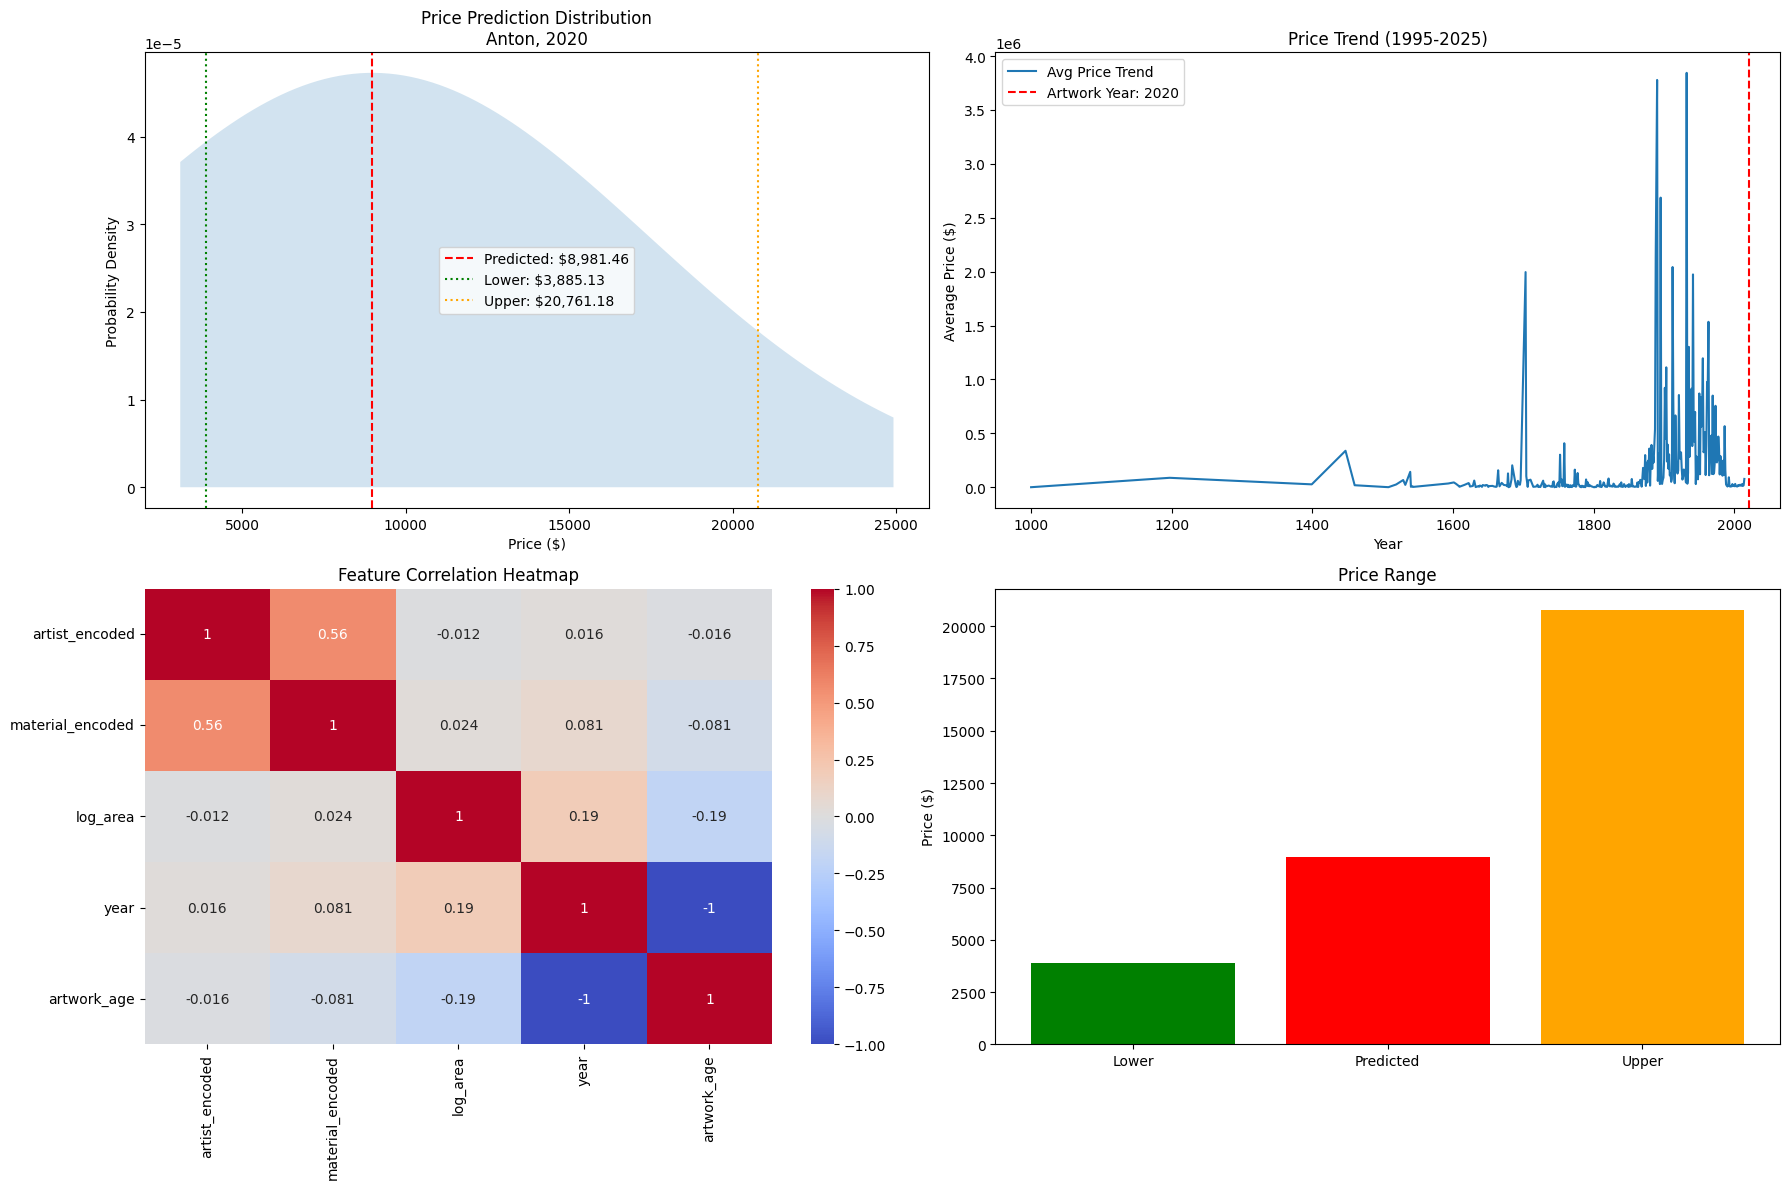

In [ ]:
import os
import joblib
from google.colab import drive

def main():
    """Main execution function"""
    print("Initializing Art Price Prediction System...")

    # Mount Google Drive and set save directory
    drive.mount('/content/drive')
    SAVE_DIR = "/content/drive/MyDrive/price_prediction_model"
    MODEL_PATH = os.path.join(SAVE_DIR, "model_bundle.joblib")

    if not os.path.exists(MODEL_PATH):
        print(f"Model bundle not found at {MODEL_PATH}. Please train and save the model first.")
        return

    # Load model components from Drive
    model_bundle = joblib.load(MODEL_PATH)
    xgb_model = model_bundle["model"]
    encoders = model_bundle["encoders"]
    std_dev = model_bundle["std_dev"]
    feature_columns = model_bundle["feature_columns"]
    df = model_bundle["dataframe"]

    print("Model loaded successfully from Drive.")
    print_feature_importances(xgb_model, feature_columns)

    while True:
        artist, year, height, width, material, country = get_user_input()
        image_path = input("Enter image path for analysis: ").strip()
        image_features = extract_image_features(image_path)

        inputs = prepare_prediction_input(
            artist, year, height, width, material, country,
            encoders, feature_columns, image_features
        )

        lower_bound, predicted_price, upper_bound = predict_price_range(
            xgb_model, inputs, std_dev, feature_columns
        )

        print("\n=== Price Prediction Results ===")
        print(f"Artist: {artist}\nDimensions: {height}cm x {width}cm\nMaterial: {material}")
        print(f"Country: {country}")
        print(f"Face Count: {image_features['FaceCount']}")
        print(f"Dominant Color: {image_features['dominantColor']}")
        print(f"Brightness: {image_features['brightness']:.2f}")
        print(f"\nEstimated price range: ${lower_bound:,.2f} - ${upper_bound:,.2f}")
        print(f"Most likely price: ${predicted_price:,.2f}")

        plot_visualizations(lower_bound, predicted_price, upper_bound, artist, year, df)

        # Explain the prediction using LIME
        explain_with_lime(xgb_model, df[feature_columns].values, feature_columns, inputs)

        while True:
            choice = input("\nPredict another price? (y/n): ").strip().lower()
            if choice in ('y', 'n'):
                break
            print("Please enter 'y' or 'n'.")
        if choice == 'n':
            break

# Standard Python entry point
if __name__ == "__main__":
    main()
